In [91]:
import nltk
import pandas as pd
import numpy as np
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from nltk.corpus import stopwords
import pickle
import re
import os

In [92]:
# Download NLTK data (you need to run this once)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [93]:
# Load the text data
file_path = "/content/metamorphosis_clean.txt"
with open(file_path, "r", encoding="utf8") as file:
    lines = file.readlines()

# Convert the list of lines into a pandas DataFrame for easier handling
df = pd.DataFrame(lines, columns=["Text"])

In [94]:
# Display the first and last lines
print(f"First Line: {df['Text'].iloc[0]}")
print(f"Last Line: {df['Text'].iloc[-1]}")

First Line: One morning, when Gregor Samsa woke from troubled dreams, he found

Last Line: first to get up and stretch out her young body.


In [95]:
# Combine all lines into one single string for processing
data = ' '.join(df['Text'].values)

In [96]:

# Text Preprocessing
def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove punctuation
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(translator)

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [97]:
# Apply cleaning
data = clean_text(data)

In [98]:
# Tokenization using NLTK
tokens = nltk.word_tokenize(data)

In [99]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
tokens = [word for word in tokens if word not in stop_words]

In [100]:
# Convert tokens back to a clean string
clean_data = ' '.join(tokens)

In [101]:
# Tokenization and sequences using Keras Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts([clean_data])

In [102]:
# Save the tokenizer for later use
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle)

In [103]:
# Convert the text into sequences of integers
sequence_data = tokenizer.texts_to_sequences([clean_data])[0]

In [62]:
# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 2437


In [104]:
# Creating sequences and preparing input-output pairs for the model
def create_sequences(sequence_data):
    sequences = []
    for i in range(1, len(sequence_data)):
        words = sequence_data[i-1:i+1]
        sequences.append(words)
    return np.array(sequences)

In [105]:
# Creating sequences from the tokenized data
sequences = create_sequences(sequence_data)

In [106]:
# Split sequences into input (X) and output (y)
X = sequences[:, 0]
y = sequences[:, 1]

In [107]:
# Convert output (y) to categorical format
y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

In [108]:
# Reshape X to add a dimension for timesteps (1 in this case)
# X = np.reshape(X, (X.shape[0], 1, 1))

In [109]:
# Model building
model = Sequential()

# Define input length explicitly for the embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=10, input_length=1))  # input_length=1 because each sequence is 1 word

# Add LSTM layers
model.add(LSTM(512, return_sequences=False))  # The LSTM layer expects 3D input: (batch_size, timesteps, features)

# Dense layers
model.add(Dense(512, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

# Now the model is built properly
model.build(input_shape=(None, 1))  # Define the input shape explicitly

# Model summary to see the layer details
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 1, 10)               │          24,370 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 512)                 │       1,071,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2437)                │       1,250,181 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,608,311 (9.95 MB)

 Trainable params: 2,608,311 (9.95 MB)

 Non-trainable params: 0 (0.00 B)

In [110]:
# Model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 1, 10)               │          24,370 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 512)                 │       1,071,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2437)                │       1,250,181 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,608,311 (9.95 MB)

 Trainable params: 2,608,311 (9.95 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
# Setting up callbacks with the updated .keras extension for model saving
checkpoint = ModelCheckpoint("nextword_model.keras", monitor='loss', verbose=1, save_best_only=True, mode='auto')

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose=1)

logdir = "logs_next_word"
tensorboard_callback = TensorBoard(log_dir=logdir)


In [112]:
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


In [113]:
# Train the model
history = model.fit(X, y, epochs=100, batch_size=64, callbacks=[checkpoint, reduce_lr, tensorboard_callback])


Epoch 1/100
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.5109
Epoch 1: loss improved from inf to 7.29951, saving model to nextword_model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 7.5069 - learning_rate: 0.0010
Epoch 2/100
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8547
Epoch 2: loss improved from 7.29951 to 6.89595, saving model to nextword_model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.8554 - learning_rate: 0.0010
Epoch 3/100
152/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8077
Epoch 3: loss improved from 6.89595 to 6.82319, saving model to nextword_model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.8083 - learning_rate: 0.0010
Epoch 4/100
154/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7440
Epoch 4: loss improved from 6.82319 to 6.77290, saving model to nextword_model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.7447 - learning_rate: 0.0010
Epoch 5/100
153/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6485
Epo

In [114]:
from tensorflow.keras.models import load_model
import pickle

# Load the trained model (use the path where your model is saved)
model = load_model('nextword_model.keras')

# Load the tokenizer you previously saved
with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)


In [117]:
import numpy as np

# Input sentence (you can change this)
input_text = "at the dull"

# Tokenize the input text
input_sequence = tokenizer.texts_to_sequences([input_text])[0]

# Padding or adjusting sequence length (if your model expects a specific input length)
# For next-word prediction, you might not need padding as you're predicting one word at a time
input_sequence = np.array(input_sequence[-1:]).reshape(1, 1)  # Take the last word and reshape for the model


In [118]:
# Predict the next word
predicted_probs = model.predict(input_sequence)

# Get the word index with the highest probability
predicted_word_index = np.argmax(predicted_probs, axis=-1)[0]

# Convert the predicted word index back to the actual word using the tokenizer's word index
predicted_word = tokenizer.index_word[predicted_word_index]

print(f"Next word prediction: {predicted_word}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Next word prediction: weather


In [90]:
def generate_text(seed_text, next_words, model, tokenizer):
    for _ in range(next_words):
        # Tokenize the current seed text
        input_sequence = tokenizer.texts_to_sequences([seed_text])[0]
        input_sequence = np.array(input_sequence[-1:]).reshape(1, 1)

        # Predict the next word
        predicted_probs = model.predict(input_sequence)
        predicted_word_index = np.argmax(predicted_probs, axis=-1)[0]

        # Get the predicted word
        predicted_word = tokenizer.index_word[predicted_word_index]

        # Append the word to the seed text
        seed_text += ' ' + predicted_word

    return seed_text

# Example of generating 10 words after the seed text
output_text = generate_text("Gregor then turned to look", 10, model, tokenizer)
print(output_text)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Gregor then turned to look while she other let turn panting to would had and


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3226
Model Loss: 2.3502135276794434


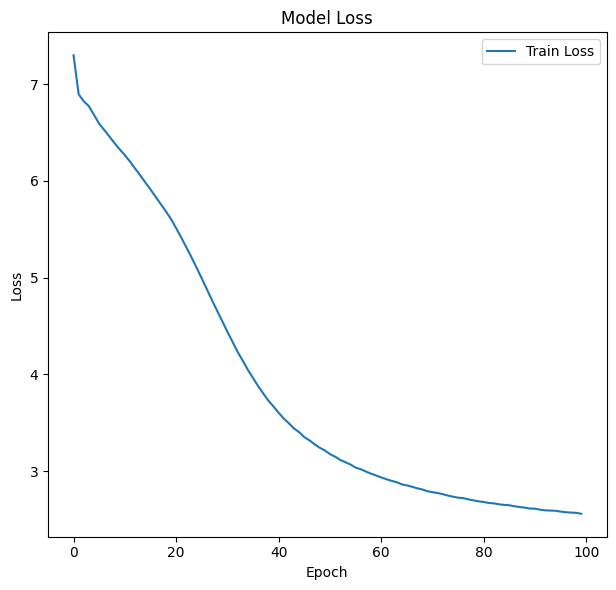

In [121]:
import matplotlib.pyplot as plt


# Step 1: Evaluate the model on the training set (you can also use a validation/test set if you have one)
loss = model.evaluate(X, y)
print(f"Model Loss: {loss}")

# Step 2: Visualize the training history
# Plot loss
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot accuracy if you have it (this assumes you added an accuracy metric when compiling the model)
if 'accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
